# 01.2a: Basic Geometric Properties

**Goal:** Explore the fundamental geometric structure of the token cloud in gamma space.

We're asking the most basic questions about our 151,936-point cloud in 2,560D space:
1. **Radial distribution:** How far are tokens from the centroid? Is there a shell structure?
2. **Pairwise distances:** What's the typical distance between two random tokens?
3. **Angular spread:** How parallel/orthogonal are token vectors? Do they fill angular space?
4. **Effective dimensionality:** Are we really using all 2,560 dimensions?

This is pure cartography—no models, no assumptions, just "what does this cloud look like?"

## Mathematical Background

For centered coordinates γ' (with centroid at origin):

**Radial distance** from centroid:
$$r_i = ||\gamma'_i||_2 = \sqrt{\sum_{j=1}^{2560} (\gamma'_{ij})^2}$$

**Pairwise distance** between tokens i and k:
$$d_{ik} = ||\gamma'_i - \gamma'_k||_2$$

**Cosine similarity** (angular measure):
$$\cos(\theta_{ik}) = \frac{\gamma'_i \cdot \gamma'_k}{||\gamma'_i|| \, ||\gamma'_k||}$$

Values near +1 = parallel, near -1 = antiparallel, near 0 = orthogonal.

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"
RANDOM_SEED = 42
COLORMAP = 'inferno'

# Sampling parameters (to avoid OOM on pairwise distances)
NUM_PAIRWISE_SAMPLES = 100_000  # Sample this many random pairs
NUM_ANGULAR_SAMPLES = 100_000   # Sample this many random pairs for angular analysis

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Centered Gamma

In [3]:
gamma_centered_path = Path(TENSOR_DIR) / "gamma_centered_qwen3_4b_instruct_2507.safetensors"
gamma_centered = load_file(gamma_centered_path)['gamma_centered']

N, d = gamma_centered.shape

print(f"Loaded γ' (gamma_centered):")
print(f"  Tokens: {N:,}")
print(f"  Dimensions: {d:,}")
print(f"  Memory: {gamma_centered.element_size() * gamma_centered.nelement() / 1024**2:.1f} MB")

Loaded γ' (gamma_centered):
  Tokens: 151,936
  Dimensions: 2,560
  Memory: 1483.8 MB


## Step 2: Radial Distribution

How far is each token from the centroid?

In [4]:
# Compute norms (radial distances from centroid)
print("Computing radial distances...")
norms = gamma_centered.norm(dim=1)

print(f"\nRadial distribution statistics:")
print(f"  Mean: {norms.mean().item():.6f} gamma units")
print(f"  Std: {norms.std().item():.6f} gamma units")
print(f"  Min: {norms.min().item():.6f} gamma units")
print(f"  Max: {norms.max().item():.6f} gamma units")
print(f"  Median: {norms.median().item():.6f} gamma units")
print(f"\nRelative variation (std/mean): {(norms.std() / norms.mean()).item():.4f}")

Computing radial distances...

Radial distribution statistics:
  Mean: 1.040134 gamma units
  Std: 0.188920 gamma units
  Min: 0.153098 gamma units
  Max: 1.568522 gamma units
  Median: 1.073374 gamma units

Relative variation (std/mean): 0.1816


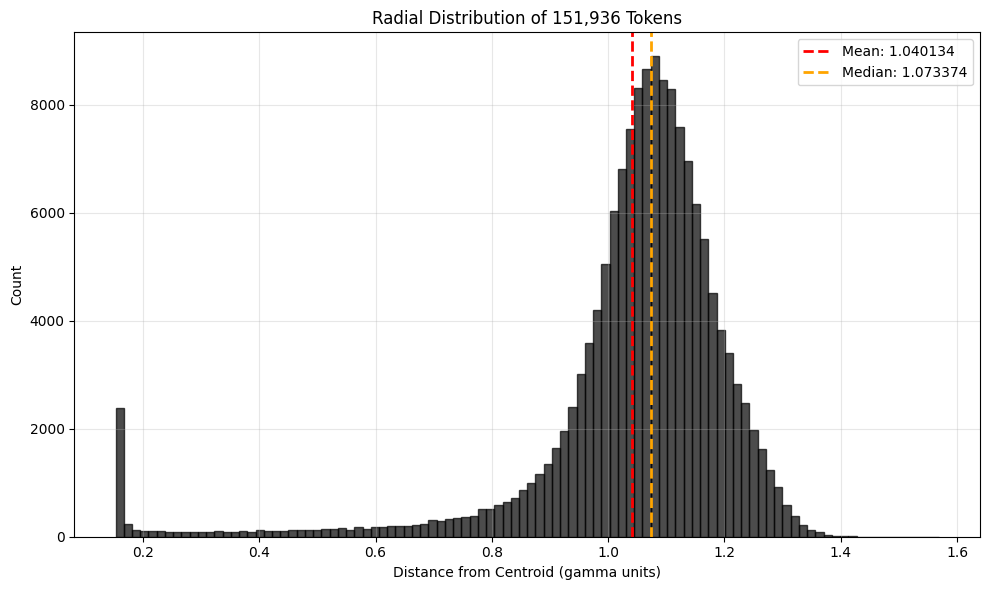

Is there a shell structure? Look for a tight peak vs broad distribution.


In [5]:
# Histogram of radial distances
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

ax.hist(norms.cpu().numpy(), bins=100, color='black', alpha=0.7, edgecolor='black')
ax.axvline(norms.mean().item(), color='red', linestyle='--', linewidth=2, label=f'Mean: {norms.mean().item():.6f}')
ax.axvline(norms.median().item(), color='orange', linestyle='--', linewidth=2, label=f'Median: {norms.median().item():.6f}')

ax.set_xlabel('Distance from Centroid (gamma units)')
ax.set_ylabel('Count')
ax.set_title(f'Radial Distribution of {N:,} Tokens')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Is there a shell structure? Look for a tight peak vs broad distribution.")

## Step 3: Pairwise Distances

Sample random pairs of tokens and measure their separation.

In [6]:
print(f"Sampling {NUM_PAIRWISE_SAMPLES:,} random token pairs...\n")

# Sample random pairs
idx_i = torch.randint(0, N, (NUM_PAIRWISE_SAMPLES,))
idx_j = torch.randint(0, N, (NUM_PAIRWISE_SAMPLES,))

# Compute pairwise distances
print("Computing pairwise distances...")
pairs_i = gamma_centered[idx_i]
pairs_j = gamma_centered[idx_j]
pairwise_distances = (pairs_i - pairs_j).norm(dim=1)

print(f"\nPairwise distance statistics:")
print(f"  Mean: {pairwise_distances.mean().item():.6f} gamma units")
print(f"  Std: {pairwise_distances.std().item():.6f} gamma units")
print(f"  Min: {pairwise_distances.min().item():.6f} gamma units")
print(f"  Max: {pairwise_distances.max().item():.6f} gamma units")
print(f"  Median: {pairwise_distances.median().item():.6f} gamma units")

Sampling 100,000 random token pairs...

Computing pairwise distances...

Pairwise distance statistics:
  Mean: 1.486062 gamma units
  Std: 0.160263 gamma units
  Min: 0.000000 gamma units
  Max: 1.953872 gamma units
  Median: 1.513577 gamma units


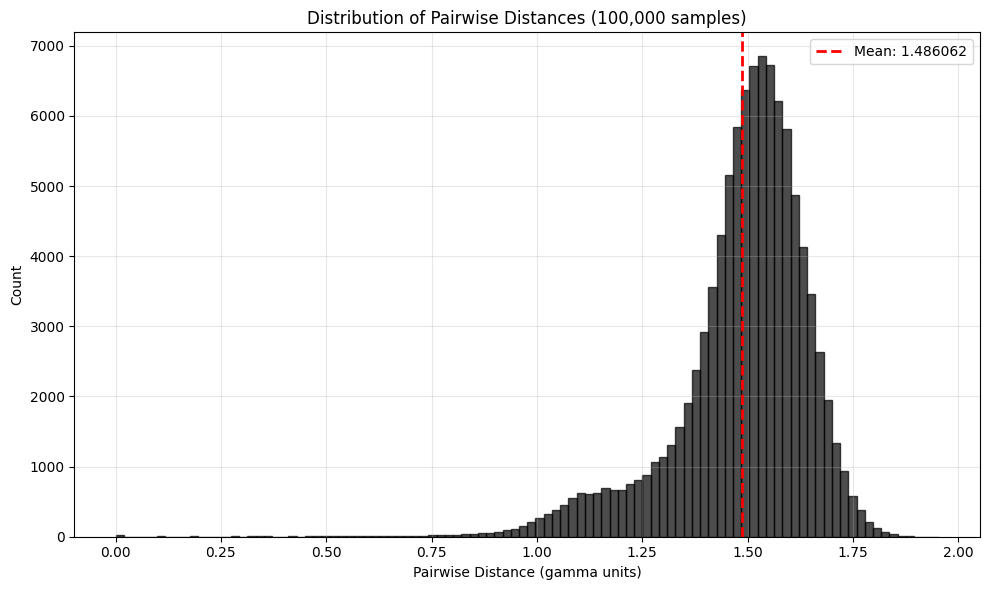


Typical separation between random tokens: ~1.486062 gamma units


In [7]:
# Histogram of pairwise distances
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

ax.hist(pairwise_distances.cpu().numpy(), bins=100, color='black', alpha=0.7, edgecolor='black')
ax.axvline(pairwise_distances.mean().item(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {pairwise_distances.mean().item():.6f}')

ax.set_xlabel('Pairwise Distance (gamma units)')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of Pairwise Distances ({NUM_PAIRWISE_SAMPLES:,} samples)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTypical separation between random tokens: ~{pairwise_distances.mean().item():.6f} gamma units")

## Step 4: Angular Spread (Cosine Similarity)

Do tokens point in similar directions or fill angular space uniformly?

In [8]:
print(f"Sampling {NUM_ANGULAR_SAMPLES:,} random token pairs for angular analysis...\n")

# Sample random pairs (reuse or resample)
idx_i = torch.randint(0, N, (NUM_ANGULAR_SAMPLES,))
idx_j = torch.randint(0, N, (NUM_ANGULAR_SAMPLES,))

# Compute cosine similarity
print("Computing cosine similarities...")
pairs_i = gamma_centered[idx_i]
pairs_j = gamma_centered[idx_j]

# Normalize to unit vectors
pairs_i_normed = pairs_i / pairs_i.norm(dim=1, keepdim=True)
pairs_j_normed = pairs_j / pairs_j.norm(dim=1, keepdim=True)

# Dot product = cosine similarity for unit vectors
cosine_similarities = (pairs_i_normed * pairs_j_normed).sum(dim=1)

print(f"\nCosine similarity statistics:")
print(f"  Mean: {cosine_similarities.mean().item():.6f}")
print(f"  Std: {cosine_similarities.std().item():.6f}")
print(f"  Min: {cosine_similarities.min().item():.6f}")
print(f"  Max: {cosine_similarities.max().item():.6f}")
print(f"  Median: {cosine_similarities.median().item():.6f}")
print(f"\nInterpretation: +1 = parallel, 0 = orthogonal, -1 = antiparallel")

Sampling 100,000 random token pairs for angular analysis...

Computing cosine similarities...

Cosine similarity statistics:
  Mean: 0.000538
  Std: 0.032301
  Min: -0.114452
  Max: 1.000000
  Median: -0.000986

Interpretation: +1 = parallel, 0 = orthogonal, -1 = antiparallel


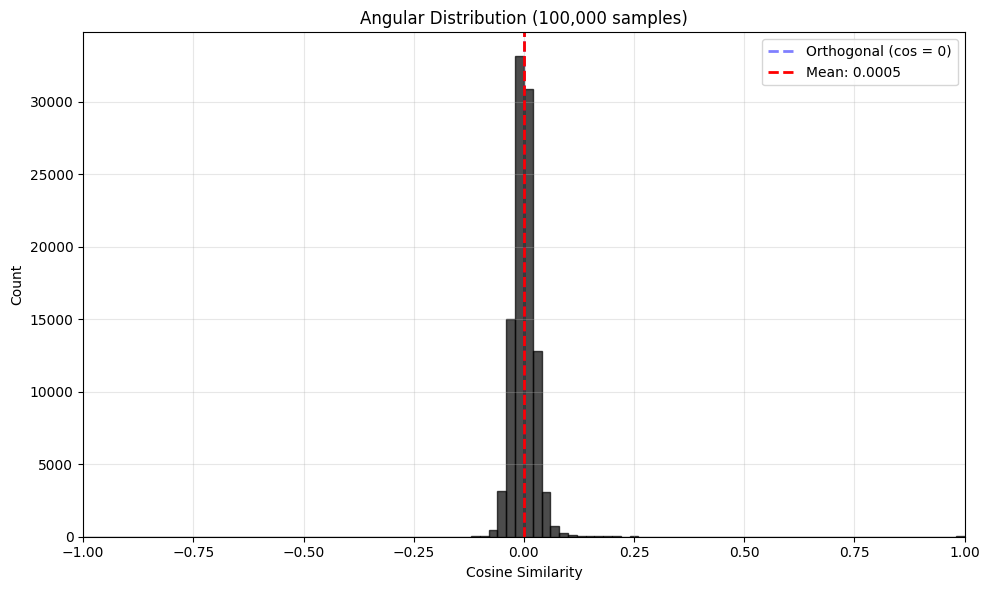

If centered near 0: tokens are roughly orthogonal (filling angular space).
If skewed toward +1: tokens cluster in certain directions.


In [9]:
# Histogram of cosine similarities
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

ax.hist(cosine_similarities.cpu().numpy(), bins=100, color='black', alpha=0.7, edgecolor='black', range=(-1, 1))
ax.axvline(0, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='Orthogonal (cos = 0)')
ax.axvline(cosine_similarities.mean().item(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {cosine_similarities.mean().item():.4f}')

ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Count')
ax.set_title(f'Angular Distribution ({NUM_ANGULAR_SAMPLES:,} samples)')
ax.set_xlim(-1, 1)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("If centered near 0: tokens are roughly orthogonal (filling angular space).")
print("If skewed toward +1: tokens cluster in certain directions.")

## Step 5: Effective Dimensionality

Quick sanity check: are we using all 2,560 dimensions, or is the data concentrated in a lower-dimensional subspace?

In [10]:
# Compute variance along each dimension
print("Computing per-dimension variance...")
variances = gamma_centered.var(dim=0)

print(f"\nPer-dimension variance statistics:")
print(f"  Mean variance: {variances.mean().item():.8f}")
print(f"  Std variance: {variances.std().item():.8f}")
print(f"  Min variance: {variances.min().item():.8f}")
print(f"  Max variance: {variances.max().item():.8f}")
print(f"  Ratio (max/min): {(variances.max() / variances.min()).item():.2f}")

# Count dimensions with "significant" variance (> 1% of max)
significant_dims = (variances > 0.01 * variances.max()).sum().item()
print(f"\nDimensions with >1% of max variance: {significant_dims} / {d}")
print(f"Effective dimensionality (rough estimate): {significant_dims / d * 100:.1f}%")

Computing per-dimension variance...

Per-dimension variance statistics:
  Mean variance: 0.00043655
  Std variance: 0.00003149
  Min variance: 0.00014620
  Max variance: 0.00071291
  Ratio (max/min): 4.88

Dimensions with >1% of max variance: 2560 / 2560
Effective dimensionality (rough estimate): 100.0%


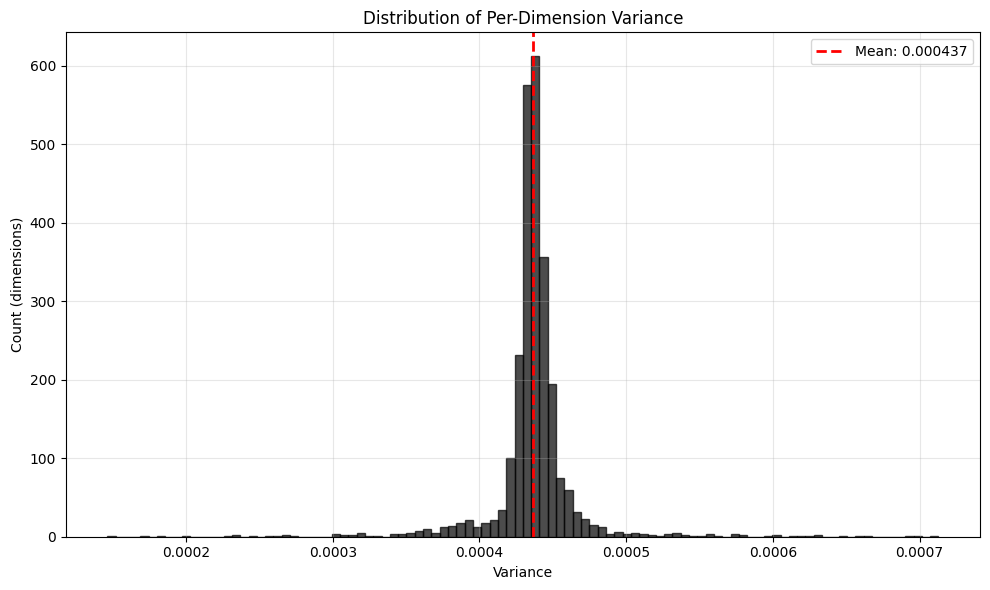

If all dimensions have similar variance: data fills the full 2,560D space.
If variance is concentrated in a few dimensions: data lives in lower-D subspace.


In [11]:
# Histogram of per-dimension variance
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

ax.hist(variances.cpu().numpy(), bins=100, color='black', alpha=0.7, edgecolor='black')
ax.axvline(variances.mean().item(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {variances.mean().item():.6f}')

ax.set_xlabel('Variance')
ax.set_ylabel('Count (dimensions)')
ax.set_title('Distribution of Per-Dimension Variance')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("If all dimensions have similar variance: data fills the full 2,560D space.")
print("If variance is concentrated in a few dimensions: data lives in lower-D subspace.")

## Summary

We've explored the basic geometry of the 151,936-token cloud in gamma space:

1. **Radial structure:** Look at the histogram—is there a tight shell or broad distribution?
2. **Pairwise distances:** Typical separation between random tokens
3. **Angular spread:** Are tokens orthogonal (cos ≈ 0) or clustered (cos > 0)?
4. **Dimensionality:** Are we using all 2,560 dimensions or living in a subspace?

This is pure observational cartography—no models imposed, just measurements. These patterns will help interpret more complex analyses later.